# State inference notebook
This notebook is used to load raw data files, infer activity states from the raw data, and visualize these actvitiy states

Copyright (C) 2020  Andrew Sonta, Rishee K. Jain

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import src.__init__ as init
timestep = init.TIME_STEP
timesteps = int(1440/timestep)

# Set fonts for plotting

# font_path = 'MyriadPro-Regular.otf'
# prop = fm.FontProperties(fname=font_path)
# matplotlib.rcParams['font.family'] = prop.get_name()

font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)

## Clean raw data files

The exact process for data cleaning will depend on the structure of the data, but in all cases we want to end up with a clean data file that has one value for each occupant at the master time step set in the `__init__.py` file.

**Missing values.** In all cases, the raw data file will occasionally have missing values. In certain plug load examples -- such as the one shown here -- the most common reason for a missing value is when the signal to the sensor does not change significantly. For example, a sensor will record 0 when all equipment is turned off, and it will not produce another reading again until some amount of power flows through it. Using this insight, the data cleansing process is as follows:
1. Remove outliers from the data (define here as 3 SD away from mean, or anything greater than 1000). These are usually caused by sensor error.
2. Resample at the interval set in our `__init__.py` file, taking the mean for values produced within this interval.
3. Forward fill any missing values produces from the resampling, as well as any missing values naturally ocurring in the data. When we have many missing values after a reading of 0, we fill with all 0s until another positive reading.

In [34]:
# Concatenate each data file into one Pandas dataframe (raw_df)
path = os.getcwd() + '/data/raw'
all_files = glob.glob(os.path.join(path, '*.csv'))
df_from_each_file = (pd.read_csv(f) for f in all_files)
raw_df = pd.concat(df_from_each_file, sort=True, ignore_index=True)

# Set the index to the column containing timestamps. Note: may need to adjust the 'Time' string depending on the data file.
raw_df.set_index('Time', inplace=True)
raw_df.index = pd.to_datetime(raw_df.index, infer_datetime_format=True)
raw_df = raw_df.sort_index()

# Remove outliers: data points greater than 3 standard deviations from each column's mean
print(raw_df.sub(raw_df.mean()).div(raw_df.std()).abs().gt(3).sum().sum()/(len(raw_df)*len(raw_df.columns)))
raw_df = raw_df.mask(raw_df.sub(raw_df.mean()).div(raw_df.std()).abs().gt(3))
# Remove outliers: data points greater than 200 and less than 0
print(raw_df.gt(200).sum().sum()/(len(raw_df)*len(raw_df.columns)))
print(raw_df.lt(0).sum().sum()/(len(raw_df)*len(raw_df.columns)))
raw_df = raw_df.mask(raw_df.gt(200))
raw_df = raw_df.mask(raw_df.lt(0))

# Fill missing data with previous values, up to a limit of the timestep
raw_df = raw_df.fillna(method='pad', limit=timestep)

# Resample to timestep
clean_data = raw_df.resample(str(timestep)+'T', label='right').mean()

# Forward fill remaining missing values
clean_data.fillna(method='pad')

# Fill any remaining NaN's with zeros (usually at beginning of file)
clean_data.fillna(0, inplace=True)

# Save data to clean csv file
clean_data = clean_data['2018-08-09':'2019-08-09']
clean_data.to_csv('data/clean-berkeley.csv')

1.95900630257044e-05
0.004038640547576331
1.2776128060241999e-06


## Infer activity states from clean data

This step uses the `state_classification.py` file in the `src` folder. An output of 0 means the file ran correctly.

In [35]:
os.system('python src/state_classification.py data/clean-berkeley.csv data/classified-berkeley.csv')

0

## Visualize activity states in context of clean data

### Time-series data for selected occupant

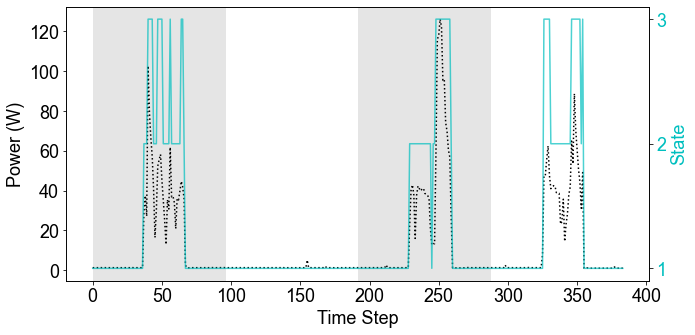

In [6]:
# Load cleansed time-series sensor data and classified activity states
clean = pd.read_csv('data/clean-berkeley.csv', index_col=0).values
classified = pd.read_csv('data/classified-berkeley.csv', index_col=0).values
dates = pd.read_csv('data/classified-berkeley.csv', index_col=0).index

# Set variables for plotting
day_range = (18, 22)
occupant = 15

# Set up plot
fig, ax1 = plt.subplots(figsize=(10,5))
# plt.rcParams.update({'font.size': 15})
ax1.set_xlabel('Time Step')
# Plot sensor data
color = 'k'
ax1.set_ylabel('Power (W)', color=color)
ax1.plot(clean[day_range[0]*timesteps:day_range[1]*timesteps, occupant-1], color=color, linestyle='dotted')
ax1.tick_params(axis='y', labelcolor=color)
# Plot activity states
ax2 = ax1.twinx()
color = 'c'
ax2.set_ylabel('State', color=color)
x = classified[day_range[0]*timesteps:day_range[1]*timesteps, occupant-1]
plt.yticks(np.arange(min(x), max(x)+1, 1.0))
ax2.plot(x, color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
# Plot days as gray background bands
for i in range(day_range[1]-day_range[0]):
    if i%2 == 0:
        plt.axvspan(i*96, i*96+96, facecolor='k', alpha=0.1)
# Display plot
fig.tight_layout() 
plt.show()

### Heatmap showing all occupants' data over the selected day

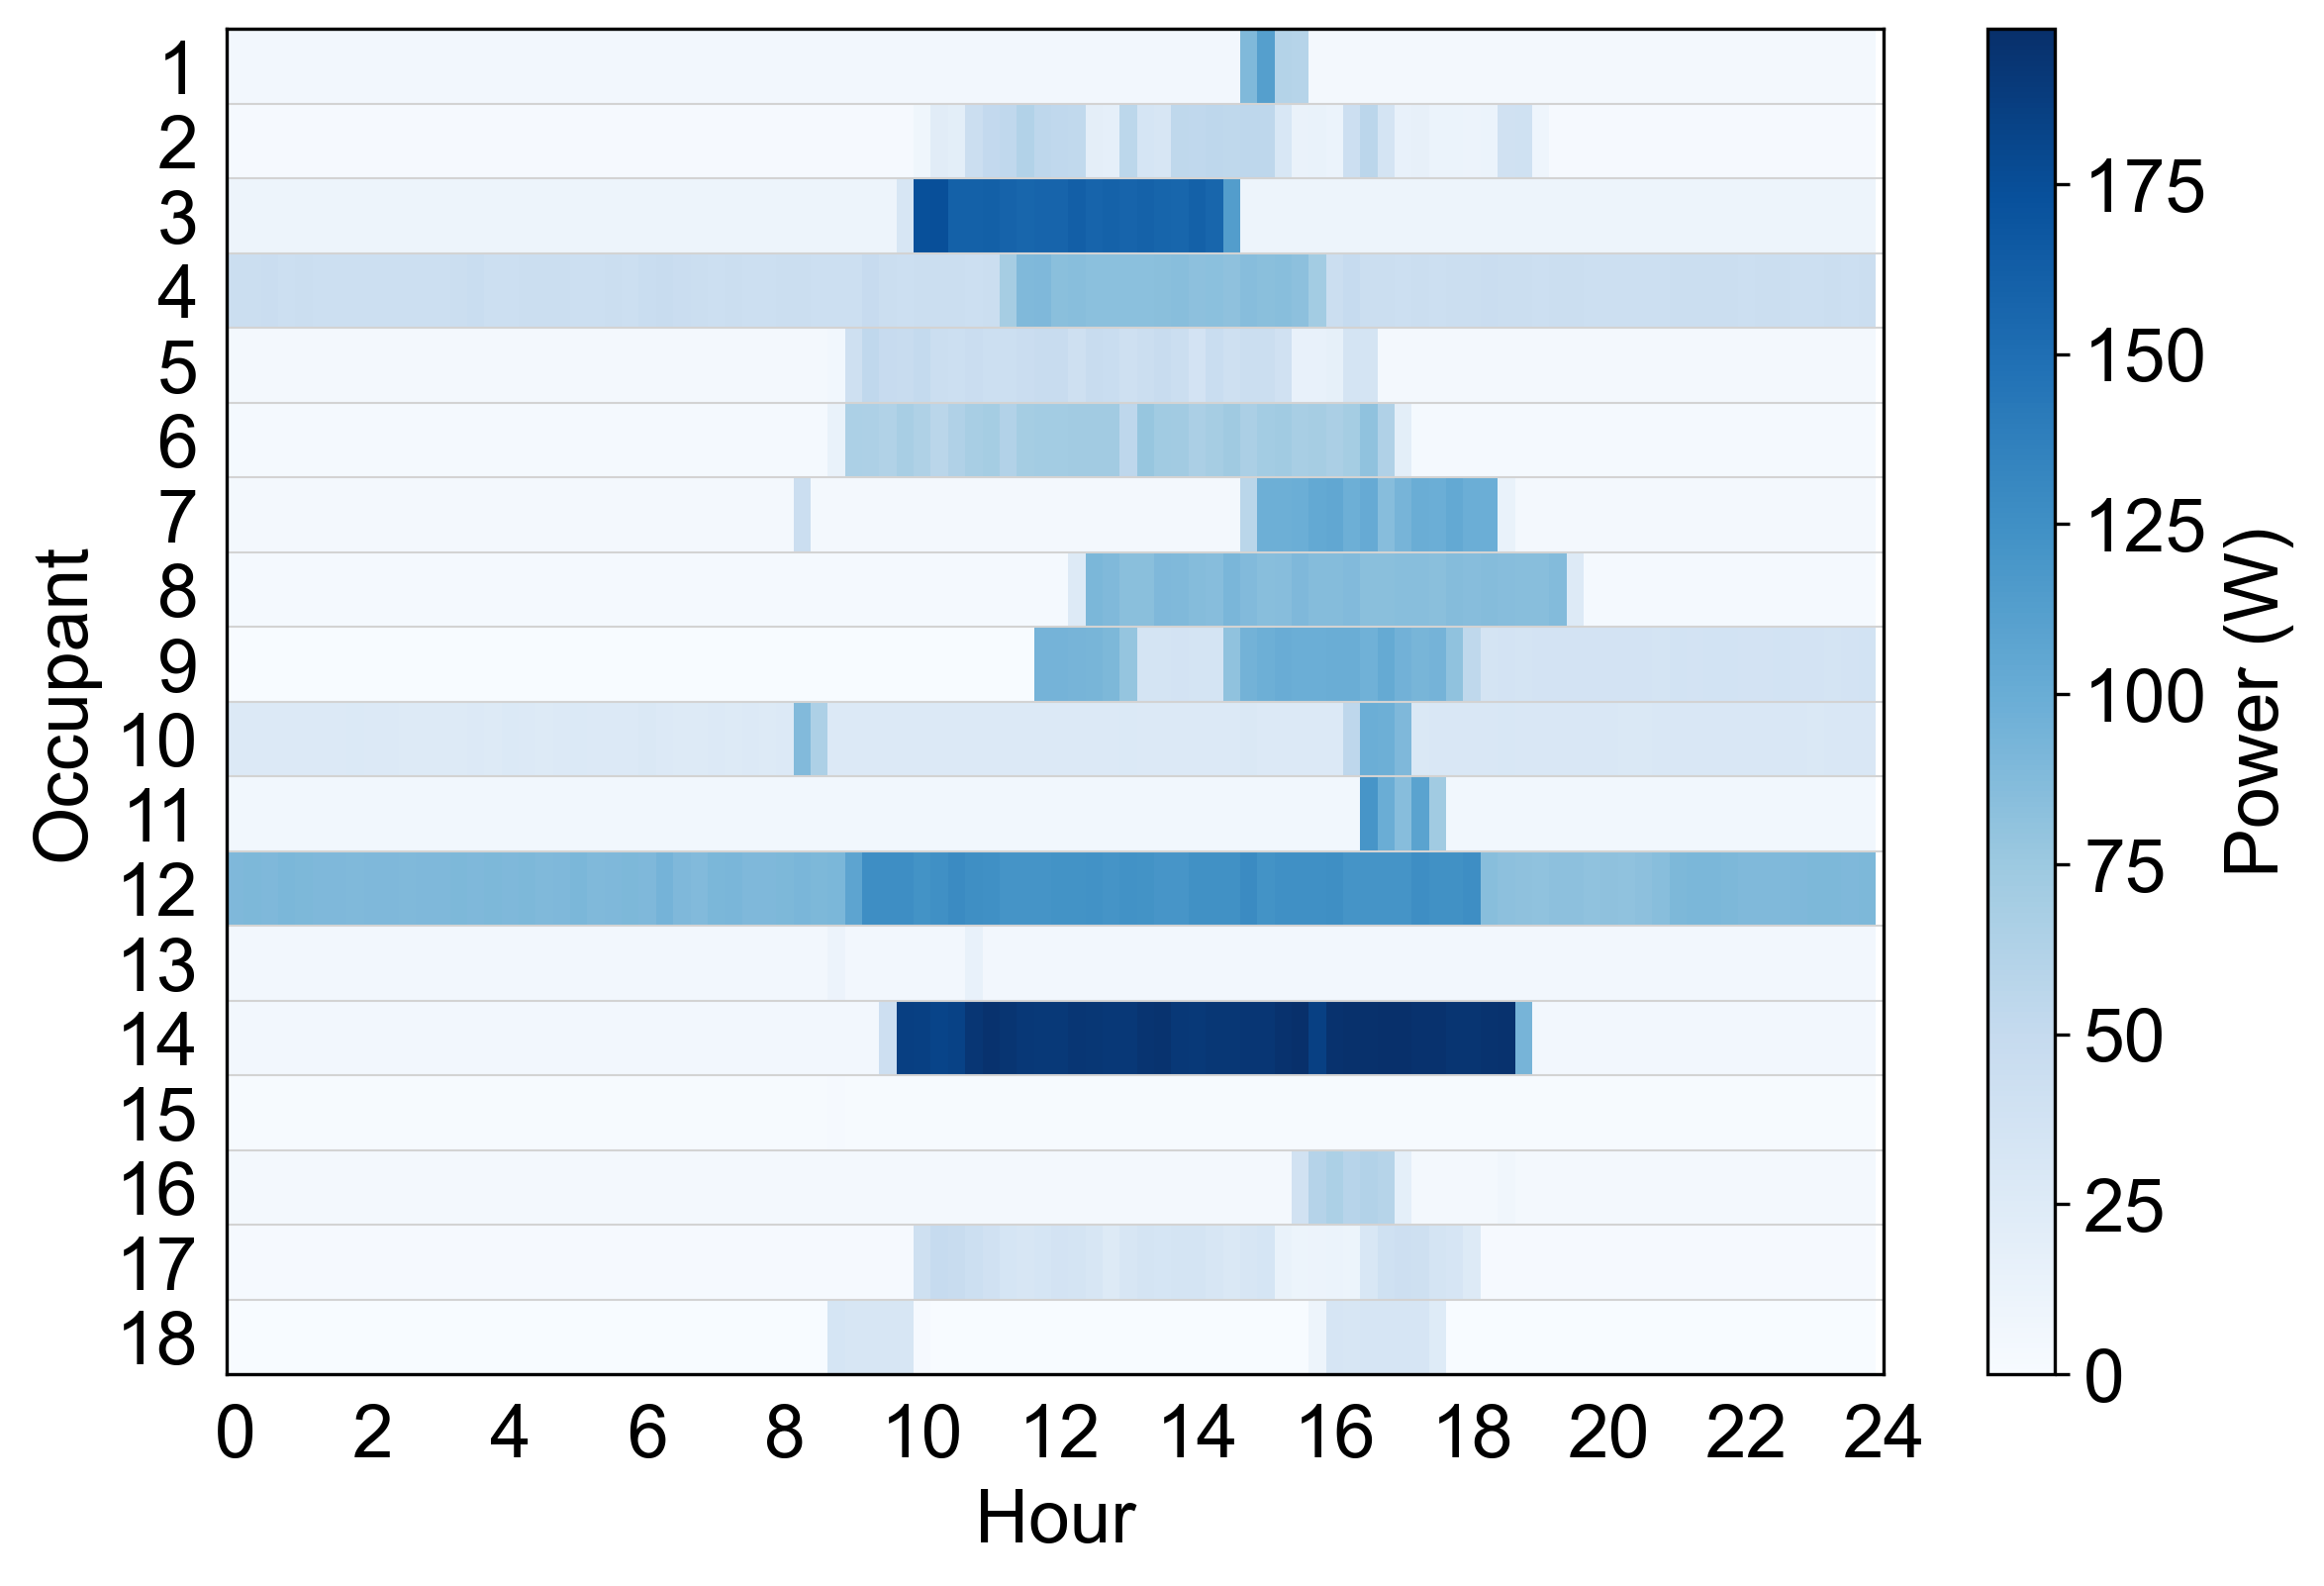

In [7]:
# Set variables for plotting
start = '2019-01-22 00:00:00'
end =   '2019-01-22 24:00:00'
classified = pd.read_csv('data/clean-berkeley.csv', index_col=0)
heatdf = classified.loc[start:end]
heatdf = heatdf.drop('Occupant 19', axis=1)
#heatdf = (heatdf - heatdf.min()) / (heatdf.max() - heatdf.min())
#heatdf = heatdf.fillna(0.0)
heatdf = heatdf.T
x_axis_labels = []
for i in range(0,97):
    if i % 8 == 0:
        x_axis_labels.append(str(int(i/4)))
    else:
        x_axis_labels.append('')
fig = plt.figure(figsize=(9,6), dpi=300)
ax = fig.add_subplot(1,1,1)  
im = plt.imshow(heatdf, cmap="Blues", aspect='auto', origin='upper')
ax.set_ylabel('Occupant')
ax.set_yticks(range(18))
ax.set_yticklabels(range(1,19))
ax.set_xlabel('Hour')
ax.set_xticks(range(0,97))
ax.set_xticklabels(x_axis_labels)
ax.tick_params(bottom=False, left=False)
fig.colorbar(im, label='Power (W)')
for i in range(18):
    plt.axhline(y=i+0.5, color='lightgray', linewidth=0.5)
plt.savefig('heatmap-power.tiff', dpi=300, bbox_inches='tight')

### Heatmap showing all occupants' activity states over the selected day

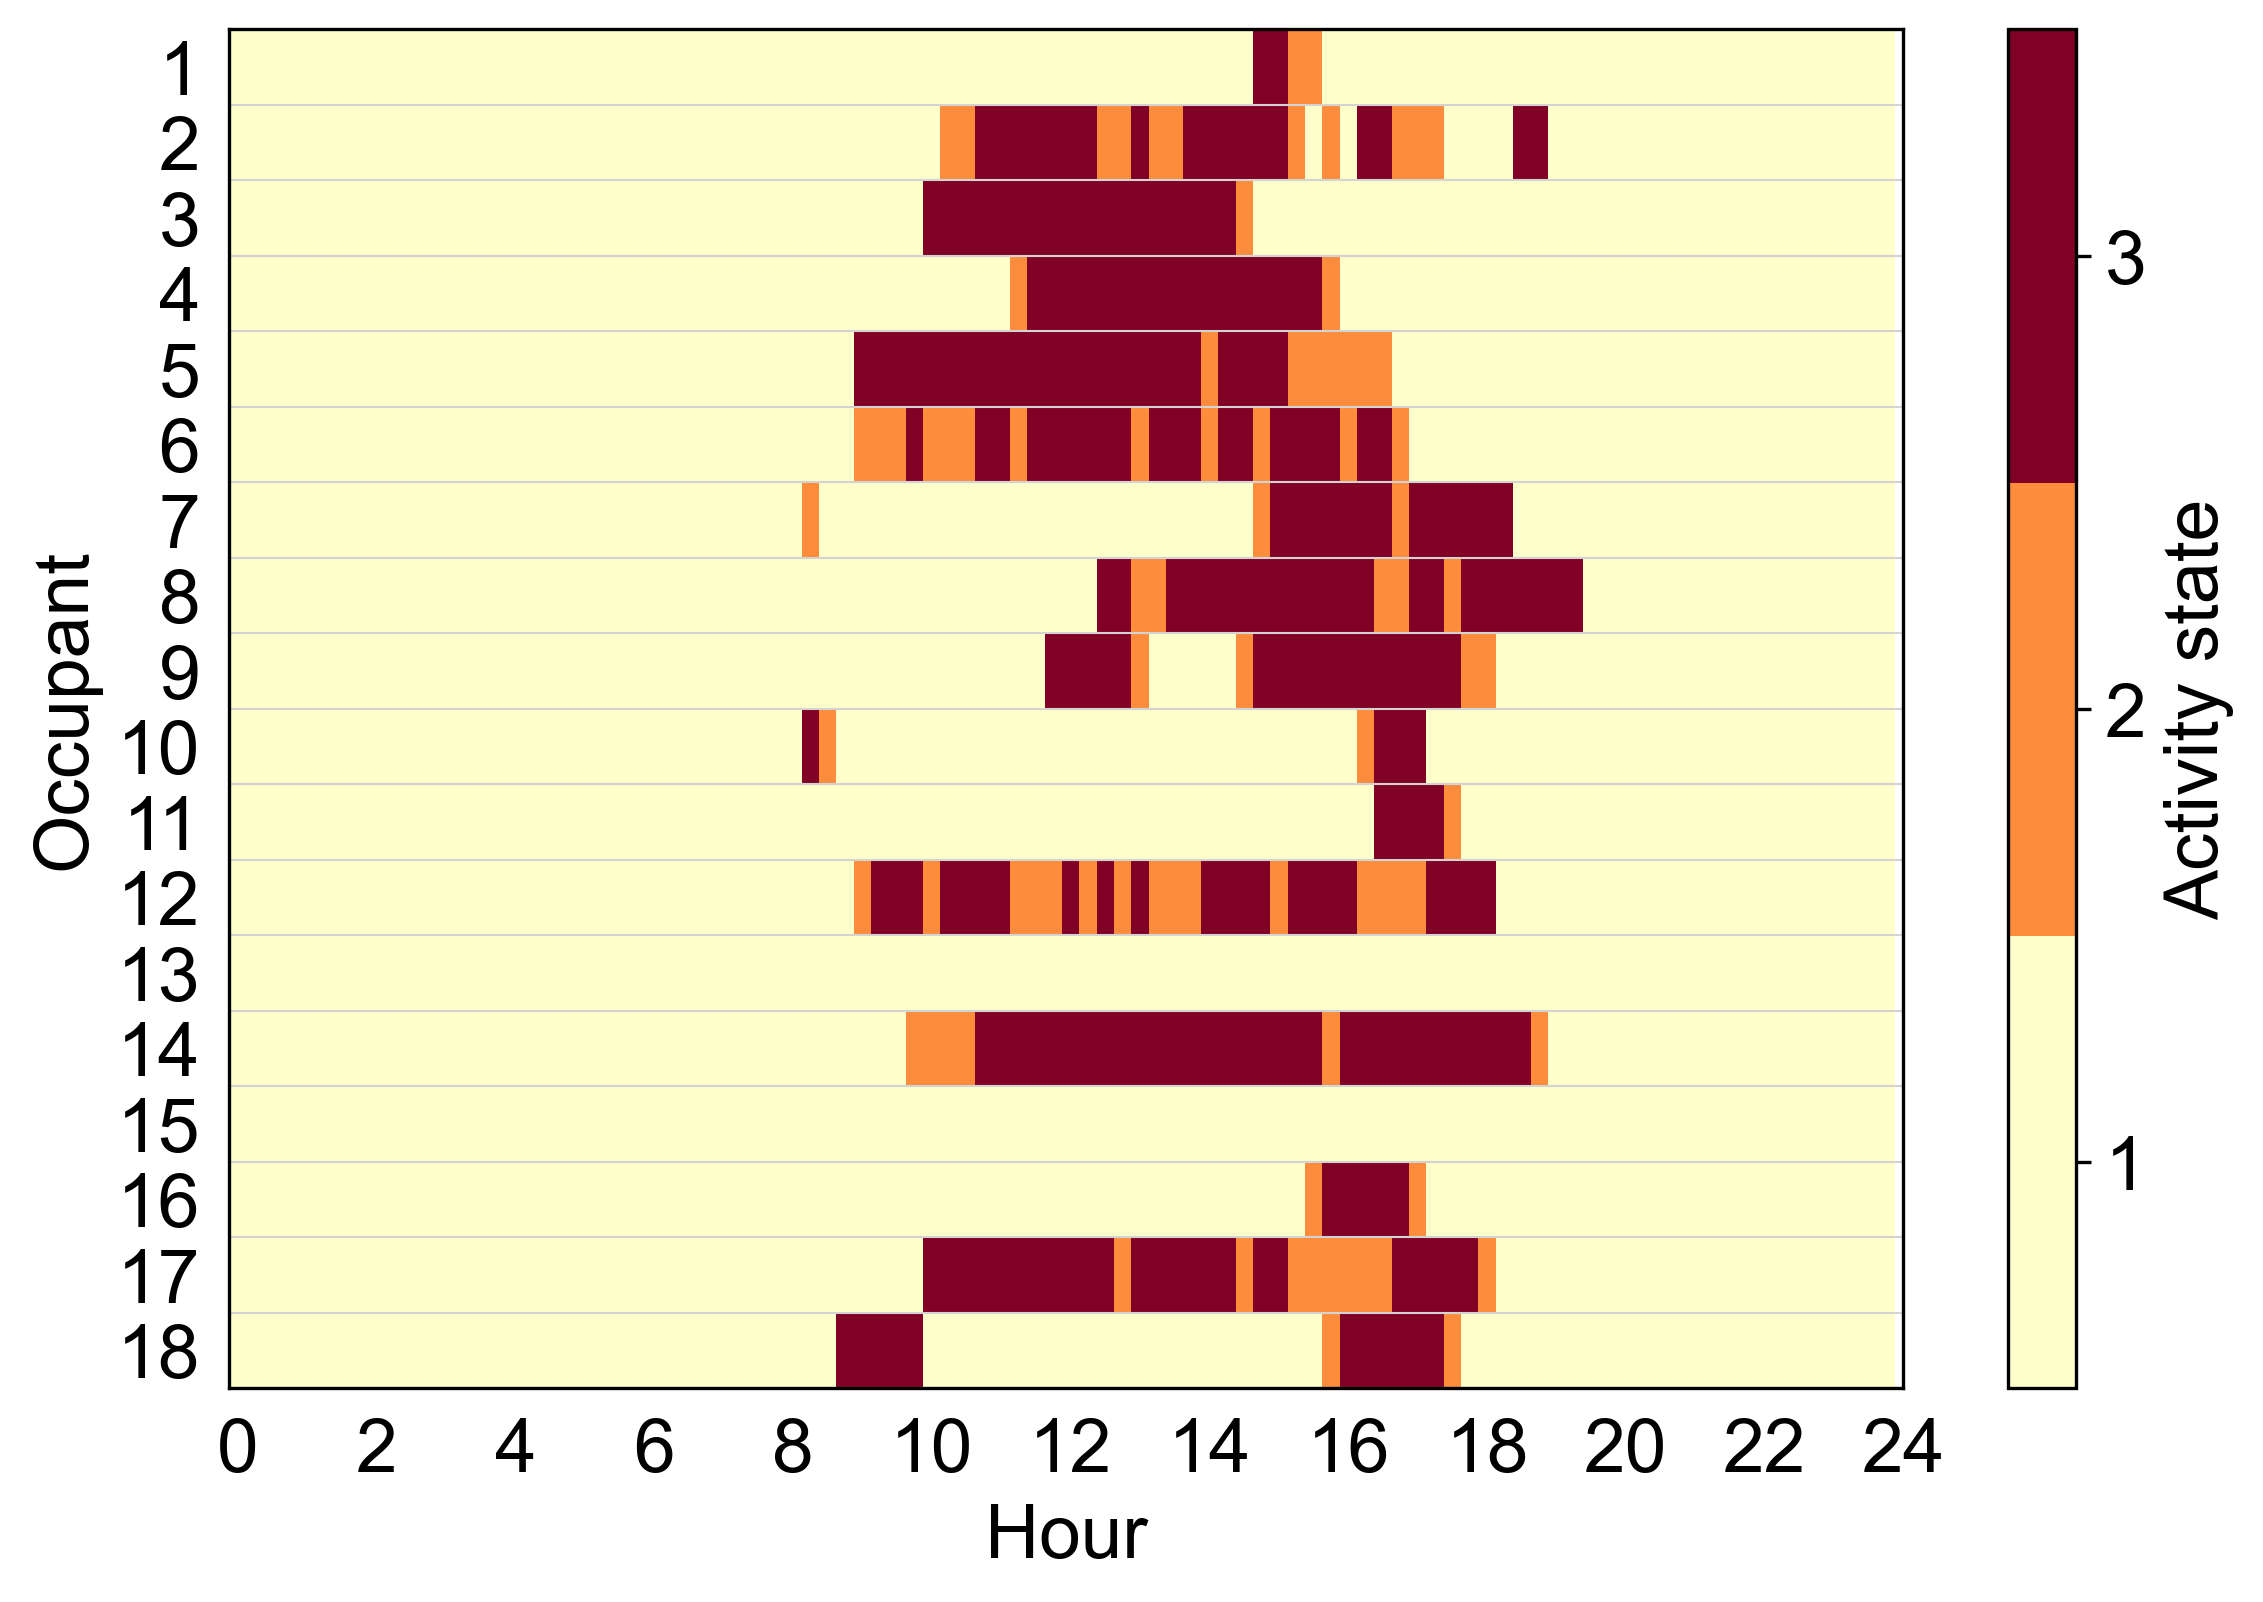

In [8]:
# Set variables for plotting
start = '2019-01-22 00:00:00'
end =   '2019-01-22 24:00:00'
classified = pd.read_csv('data/classified-berkeley.csv', index_col=0)
heatdf = classified.loc[start:end]
heatdf = heatdf.drop('Occupant 19', axis=1)
#heatdf = (heatdf - heatdf.min()) / (heatdf.max() - heatdf.min())
#heatdf = heatdf.fillna(0.0)
heatdf = heatdf.T
fig = plt.figure(figsize=(9,6), dpi=300)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Occupant')
ax.set_yticks(range(18))
ax.set_yticklabels(range(1,19))
im = plt.imshow(heatdf, cmap=plt.cm.get_cmap('YlOrRd', 3), aspect='auto', origin='upper', norm=None)
ax.set_xlabel('Hour')
ax.set_xticks(range(0,97))
ax.set_xticklabels(x_axis_labels)
ax.tick_params(bottom=False, left=False)

# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=[1,2,3], label='Activity state')

for i in range(18):
    plt.axhline(y=i+0.5, color='lightgray', linewidth=0.5)

# Set the clim so that labels are centered on each block
plt.clim(0.5, 3.5)

#fig.colorbar(im, label='Activity state')
plt.savefig('heatmap-states.tiff', dpi=300, bbox_inches='tight')
plt.show()